In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

model_name1='k_fold_best_model_test'

In [3]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [4]:
k1=0
cantera_species=pd.read_csv(name_11+str(Ts[k1])+name_12+str(phis[k1])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k1])+name_22+str(phis[k1])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [5]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [8]:
n_models=4
all_scores=np.zeros((n_models,1+n_columns_mass_fraction))

In [9]:
for j in range(n_models):
    model_name=model_name1+str(j+1)
    Autoencoder = tf.keras.models.load_model(model_name, compile=False)
    results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[0:time_cut_position,1:2+n_columns_mass_fraction].to_numpy()))).numpy()
   
    model_outputs=pd.DataFrame(results, columns=columns[1:2+n_columns_mass_fraction])
    
    from sklearn.metrics import mean_absolute_error
    for k in range(1+n_columns_mass_fraction):
        all_scores[j,k]=mean_absolute_error(dataset.iloc[0:time_cut_position,k+1],model_outputs.iloc[:,k])

In [10]:
#import seaborn as sns
import matplotlib.pyplot as plt 

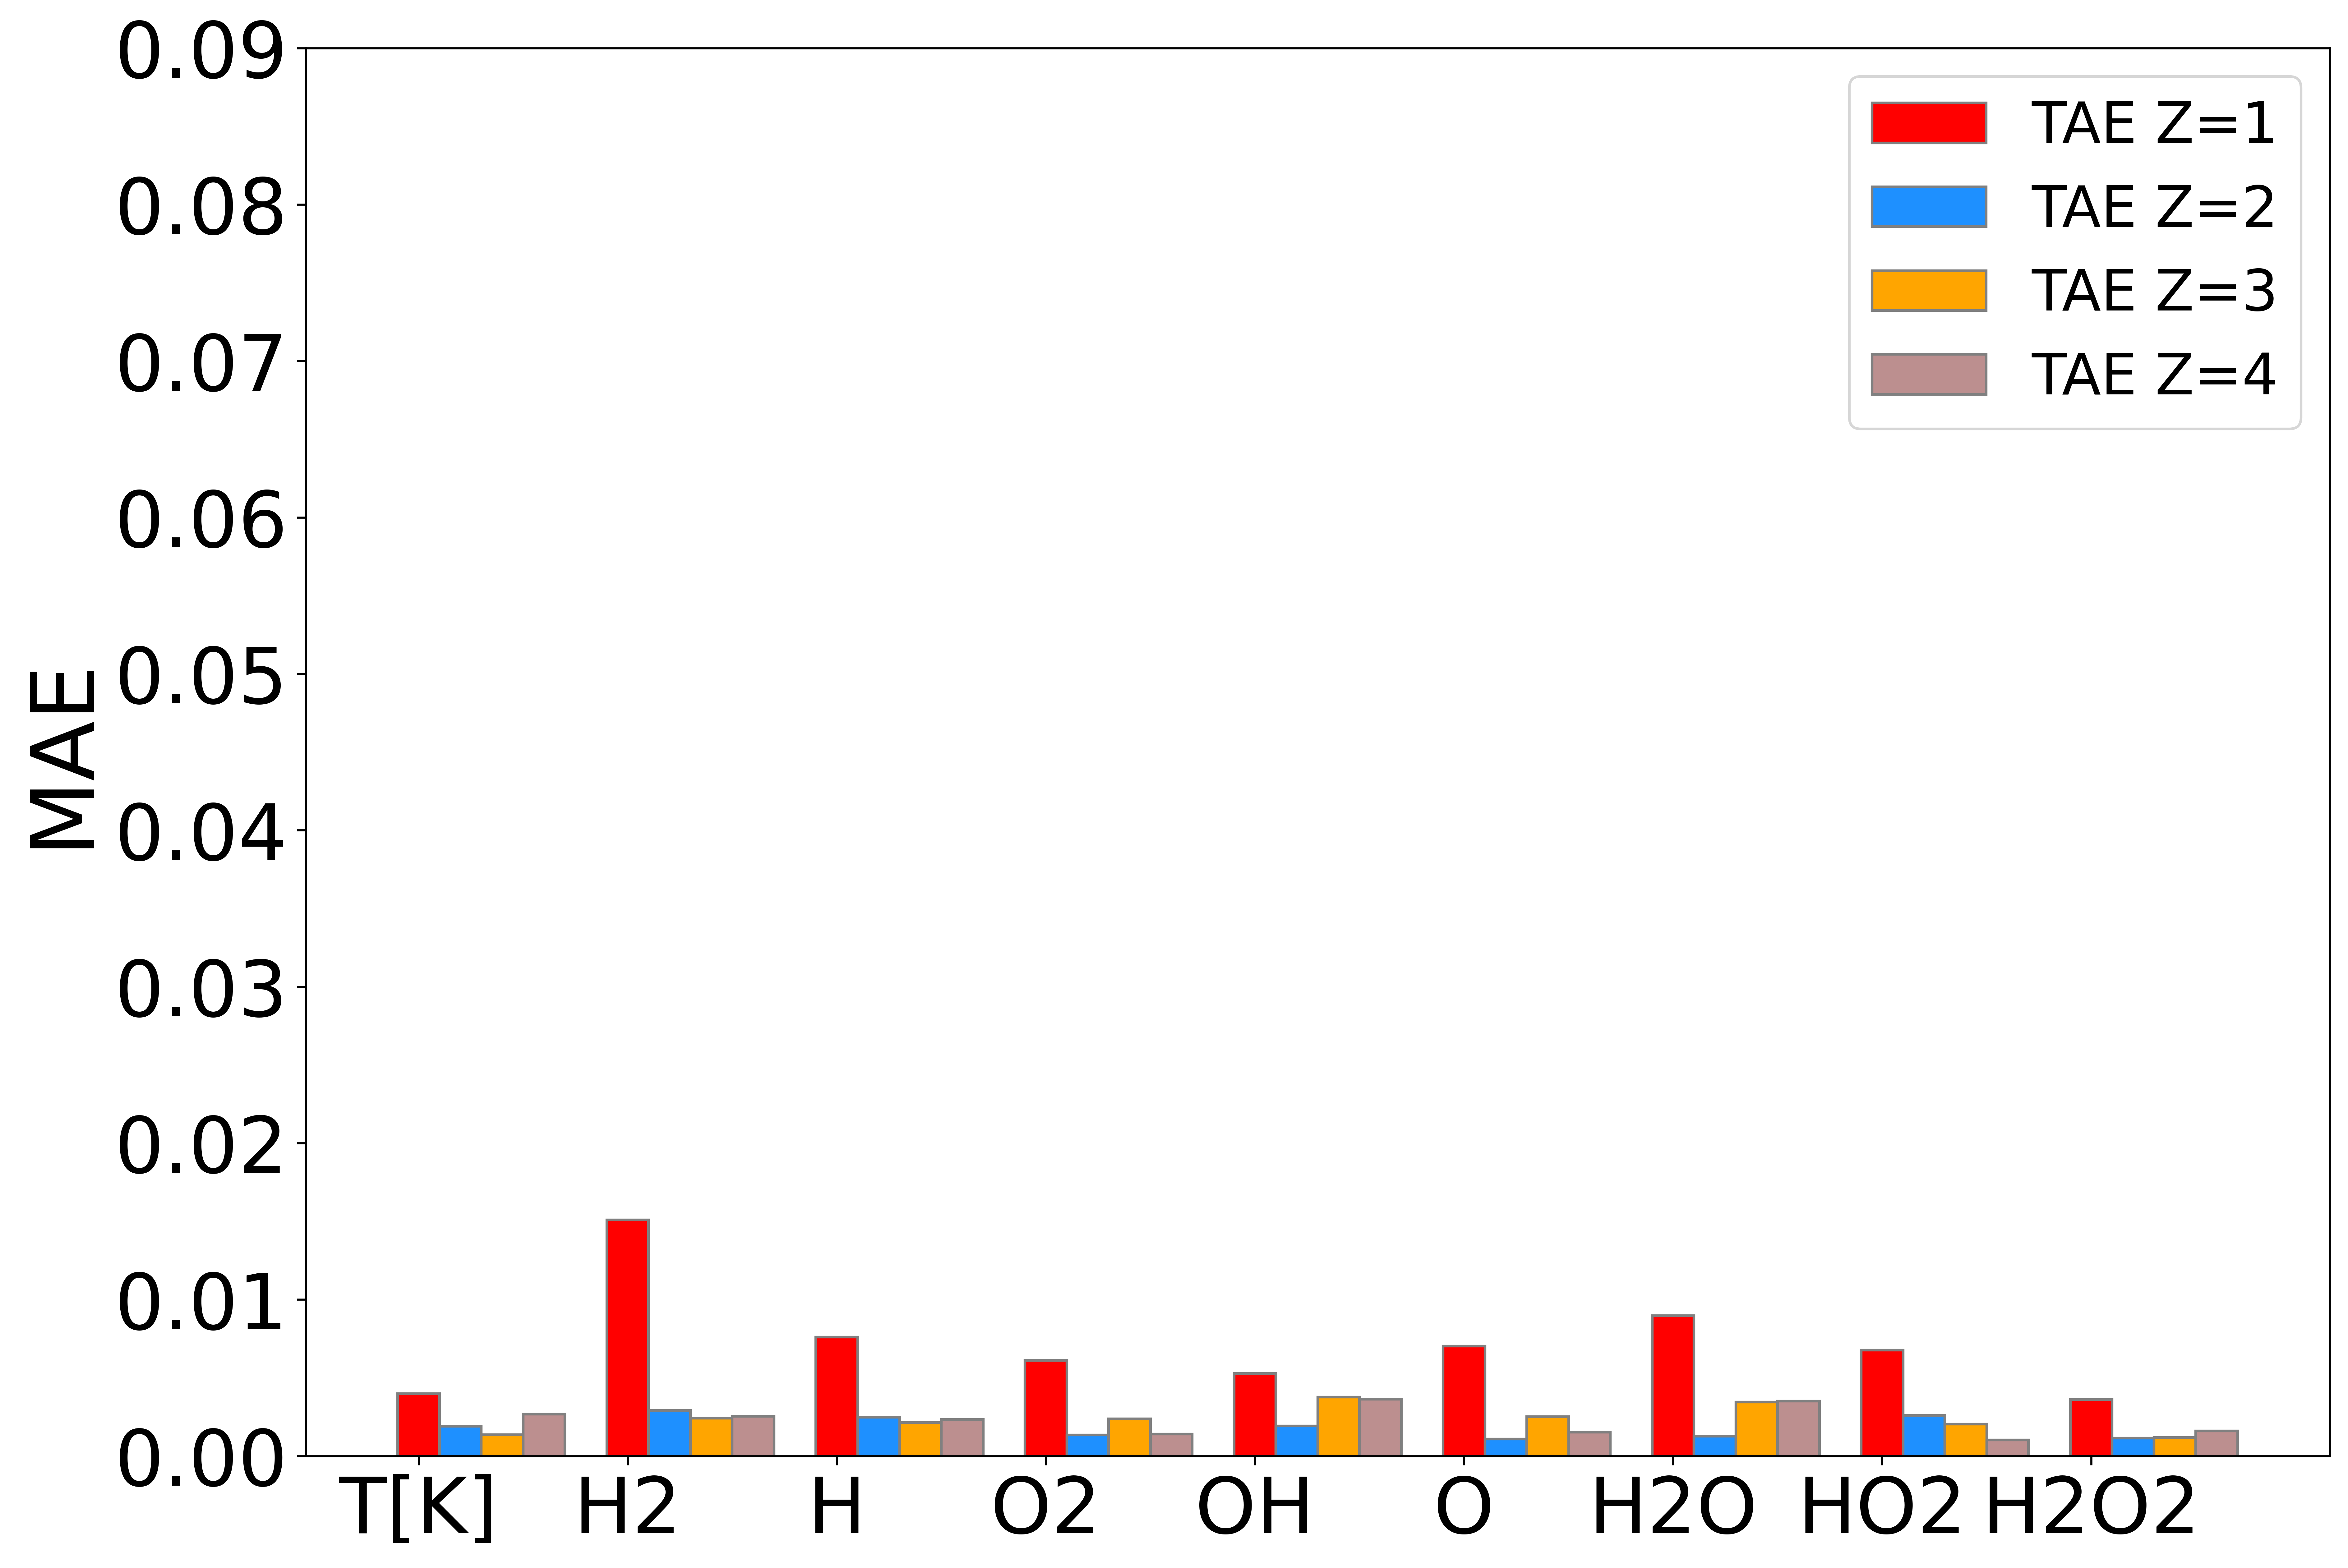

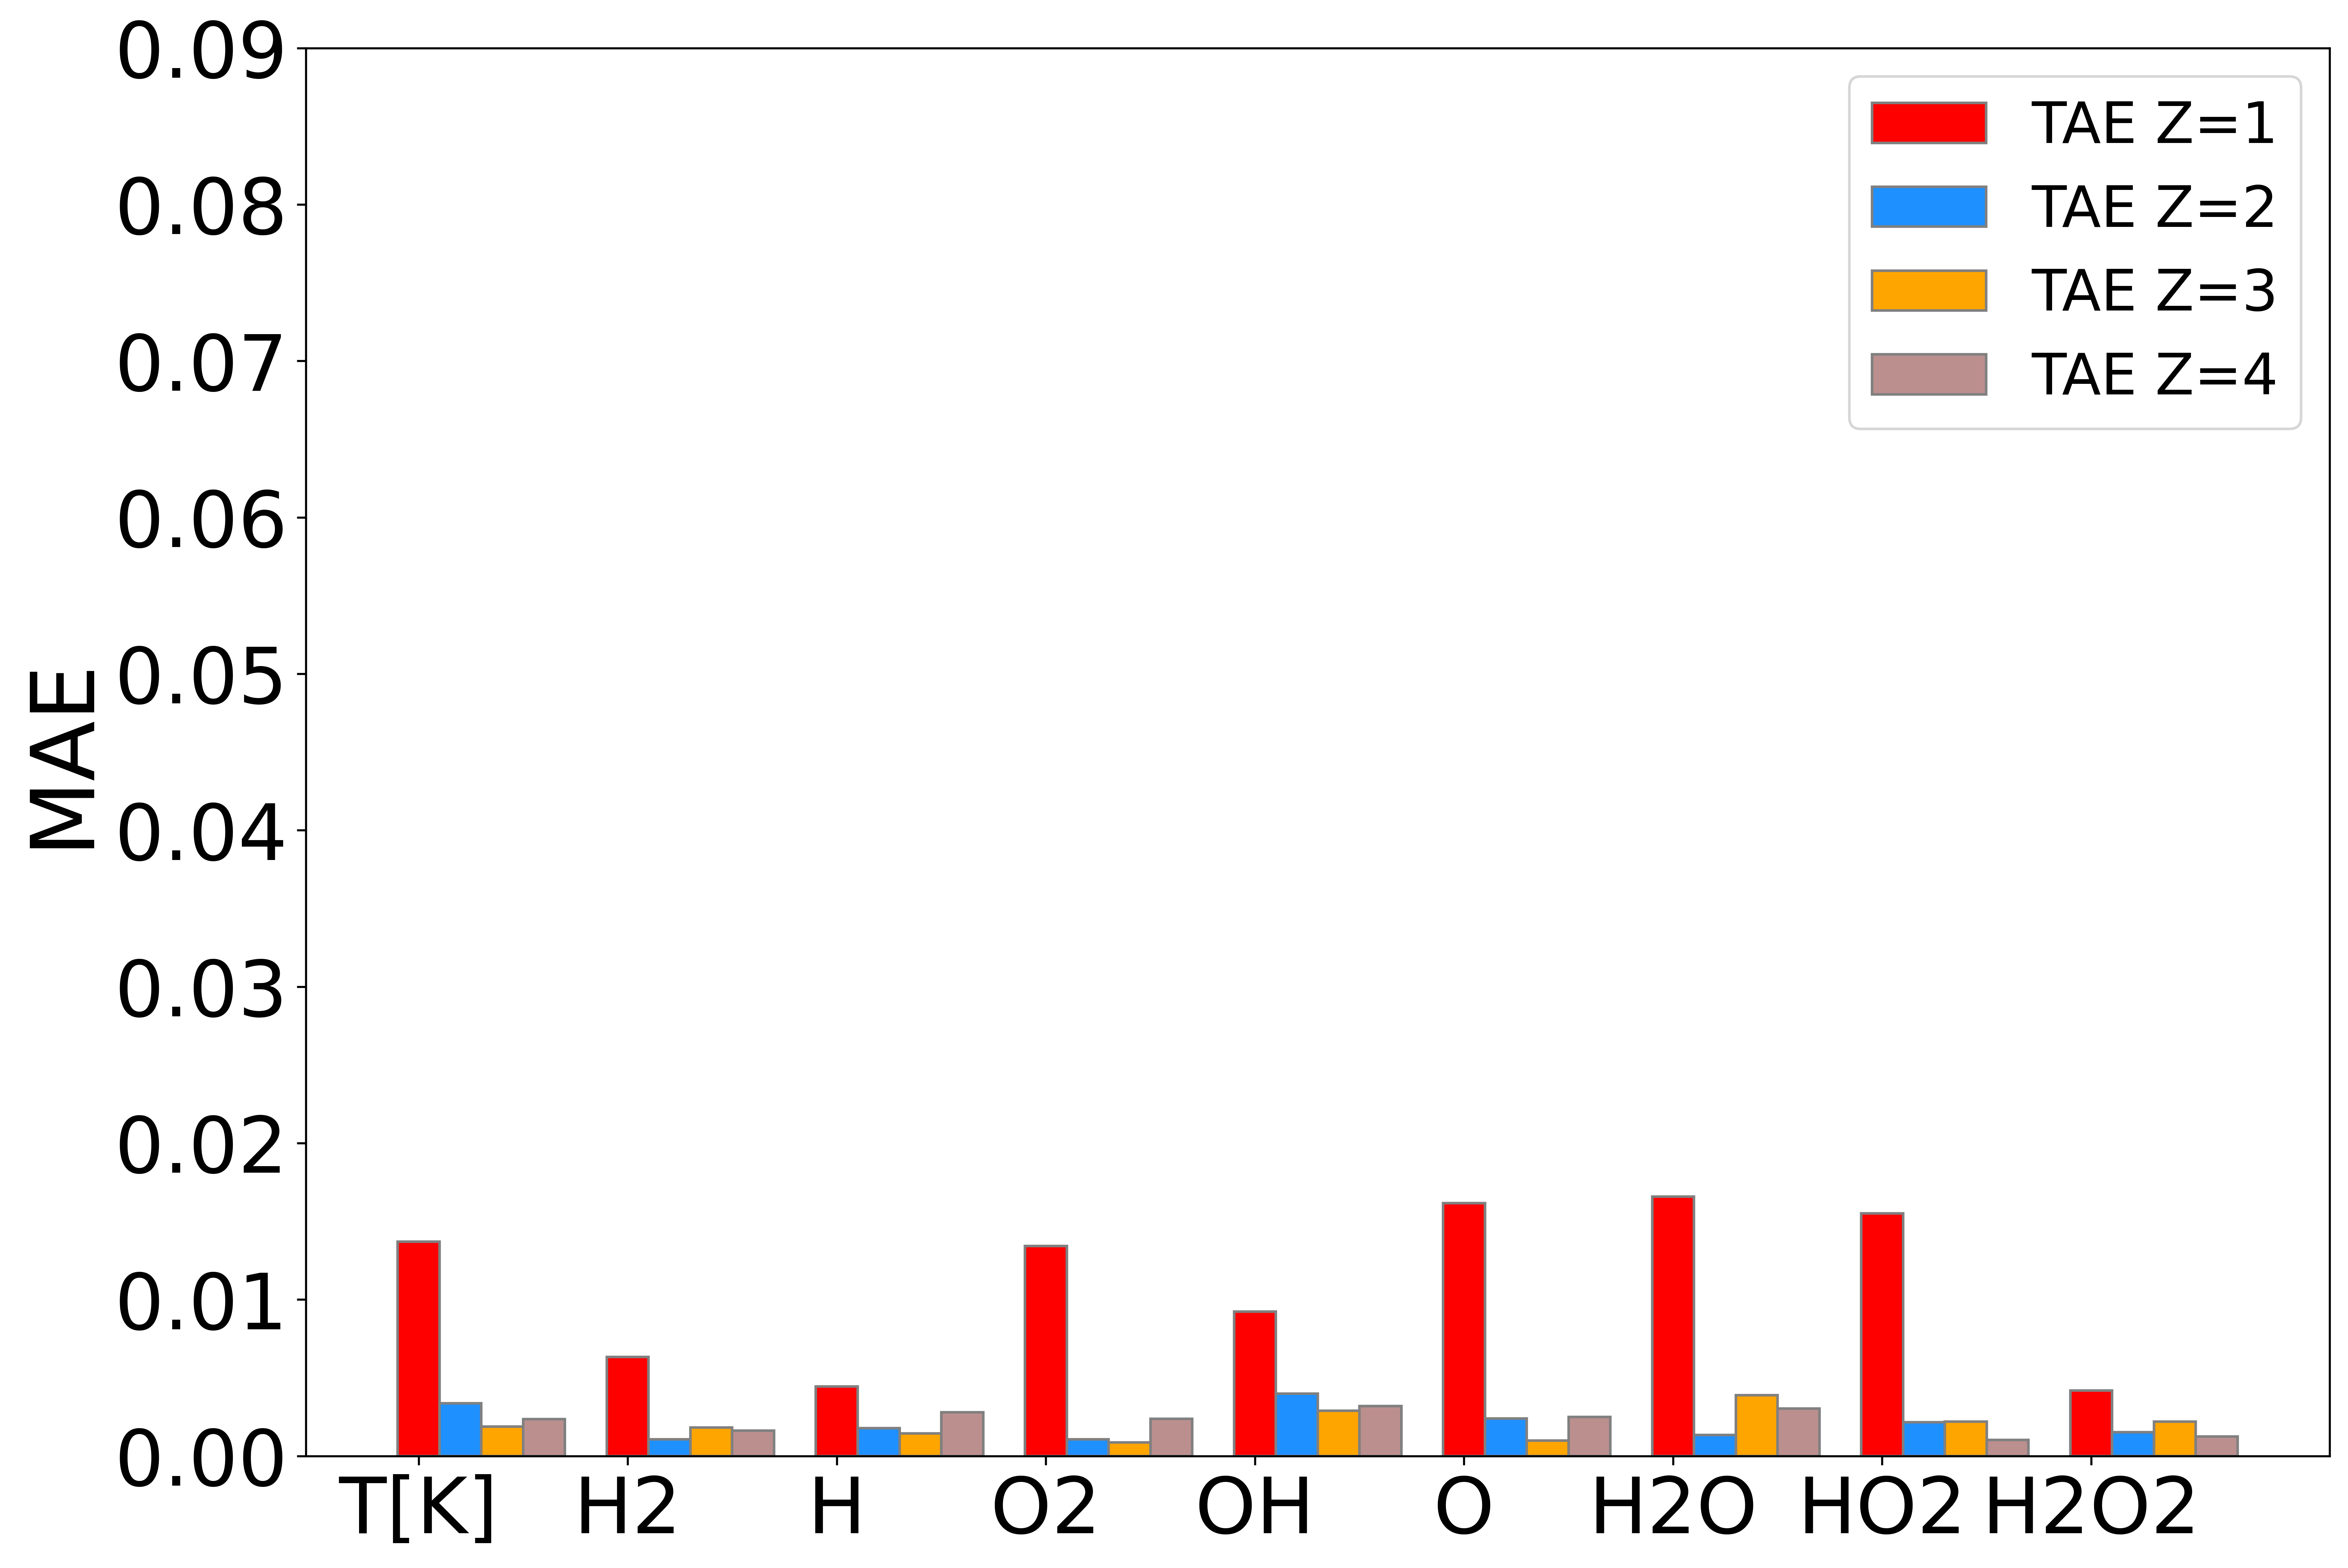

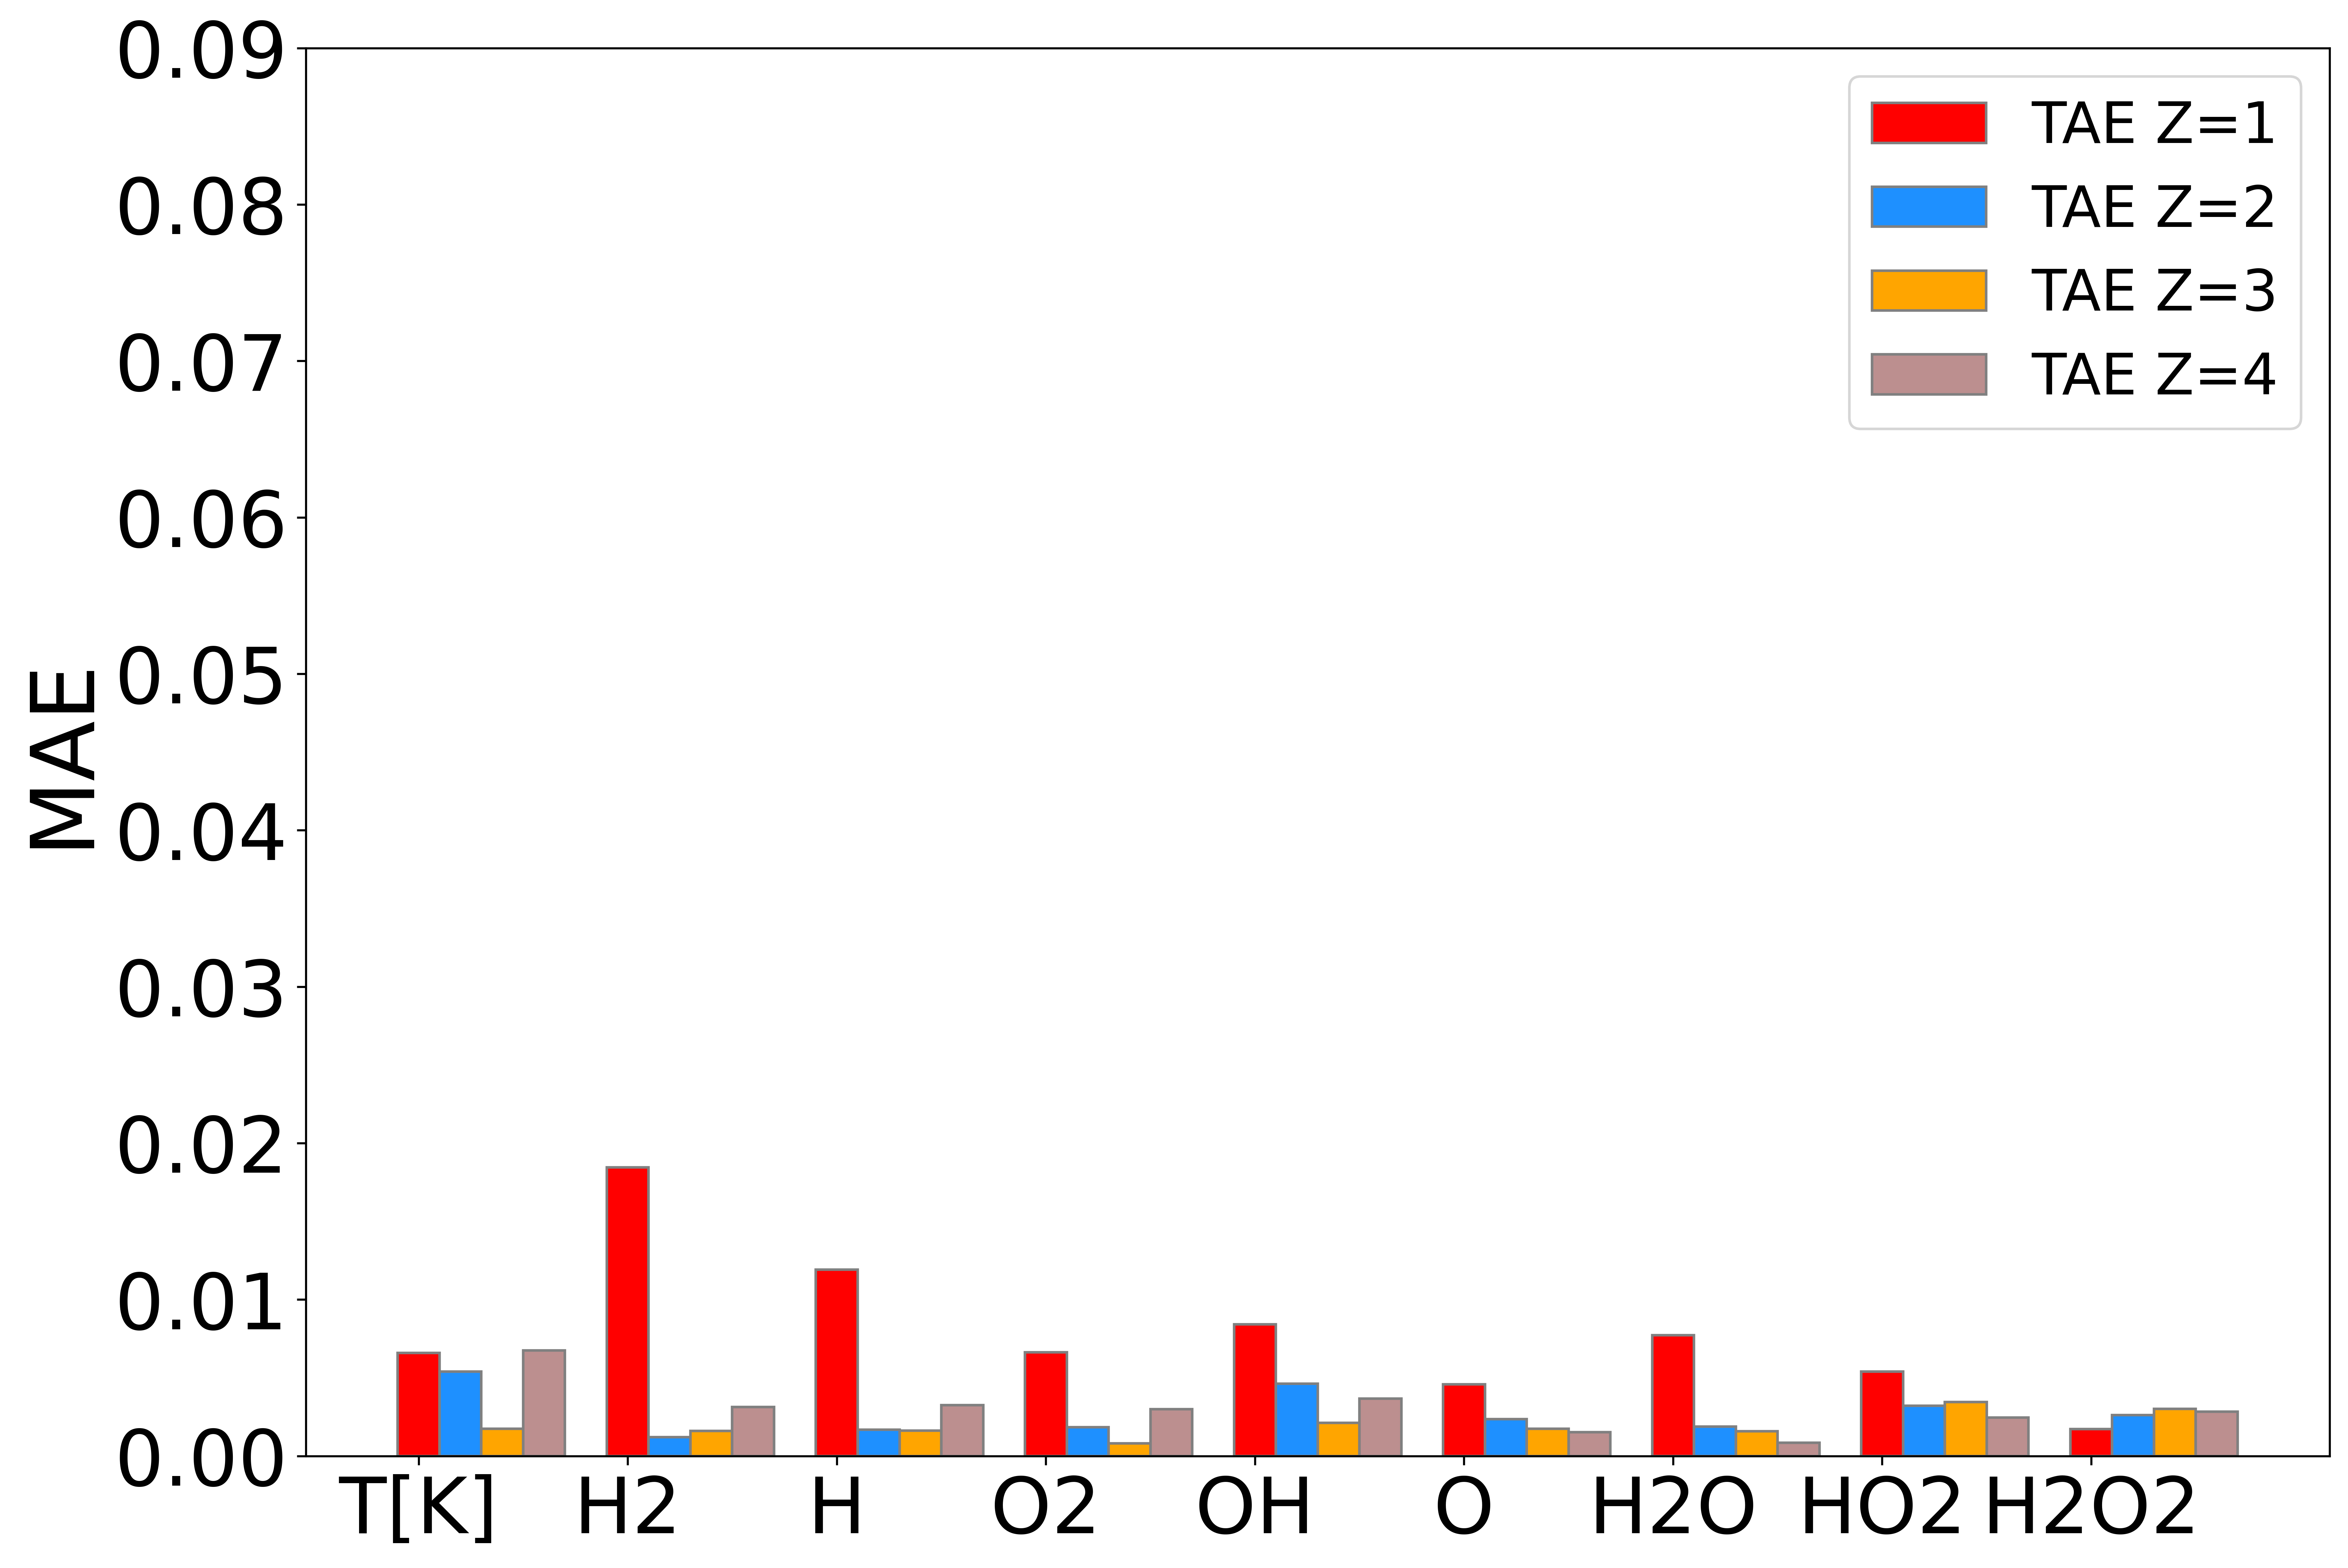

In [14]:
#fig, axn = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(24,8))
#cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(len(phis)):
    cantera_species=pd.read_csv(name_11+str(Ts[i])+name_12+str(phis[i])+end)
    cantera_species=pd.DataFrame(cantera_species)

    cantera_sources=pd.read_csv(name_21+str(Ts[i])+name_22+str(phis[i])+end)
    cantera_sources=pd.DataFrame(cantera_sources)

    maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
    maximum_values=pd.DataFrame(maximum_values)
    
    dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)
    
    for j in range(n_models):
        model_name=model_name1+str(j+1)
        Autoencoder = tf.keras.models.load_model(model_name, compile=False)
        results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()
        
        model_outputs=pd.DataFrame(results, columns=columns[1:2+n_columns_mass_fraction])
        
        from sklearn.metrics import mean_absolute_error
        for k in range(1+n_columns_mass_fraction):
            all_scores[j,k]=mean_absolute_error(dataset.iloc[:,k+1],model_outputs.iloc[:,k])
    
    barWidth = 0.2
    br1 = np.arange(1+n_columns_mass_fraction)+1
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
        
        
    fig,ax = plt.subplots(figsize =(14, 10),dpi=600)
    # Make the plot
    p1=ax.bar(br1, all_scores[0,:], color ='red', edgecolor ='grey',width = barWidth, label ='TAE Z=1')
    p2=ax.bar(br2, all_scores[1,:], color ='dodgerblue', edgecolor ='grey',width = barWidth, label ='TAE Z=2')
    p3=ax.bar(br3, all_scores[2,:], color ='orange', edgecolor ='grey',width = barWidth, label ='TAE Z=3')
    p4=ax.bar(br4, all_scores[3,:],color='rosybrown',edgecolor ='grey',width = barWidth, label ='TAE Z=4' )
    #p5=ax.bar(br4, O2_weights,color='darkorange',edgecolor ='grey',width = barWidth, label ='O2' )
        
    ax.set_ylabel('MAE', fontsize = 34)
    plt.xticks(fontsize=30)
    ax.set_xticks(br1,labels=columns[1:2+n_columns_mass_fraction],fontsize=30)
    plt.ylim([0,0.09])
    #plt.xlabel(fontsize=30)
    #plt.legend(loc='best', fontsize=25)
    plt.yticks(fontsize=30)
    plt.legend(loc='best',fontsize=22)
    plt.savefig(f'TAE_MAE_values_all_models_ignition_case{i+1}.jpg',dpi=600)
    plt.show()
        #df = pd.DataFrame(all_scores, index=[1,2,3,4],columns=columns[1:2+n_columns_mass_fraction])
    
    
    #for l, ax in enumerate(axn.flat):
        #sns.set(font_scale=2.5)
        #plt.xticks(fontsize=22)
        #plt.yticks(fontsize=22)
        #sns.heatmap(df, ax=ax,cmap="viridis",
                #cbar=l == 0,
                #vmin=0, vmax=0.04,
                #cbar_ax=None if l else cbar_ax)
        #plt.ylabel('MAE')
        
        #fig.tight_layout(rect=[0, 0, .9, 1])
    #plt.savefig('time_series_TAE_MAE.jpg',dpi=400)